In [70]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv("clean_data.csv")

In [73]:
df.to_csv('dataset/classification.csv', index=False)

In [39]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['red_score', 'blue_score'])
y_general = df[['red_score', 'blue_score']]

x_train, x_test, y_train, y_test = train_test_split(x, y_general, test_size=0.3, random_state=8)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=8)

y_red_train = y_train['red_score']
y_blue_train = y_train['blue_score']

y_red_test = y_test['red_score']
y_blue_test = y_test['blue_score']

y_red_val = y_val['red_score']
y_blue_val = y_val['blue_score']


In [40]:
print(len(y_blue_test), "\n\n")
print(len(y_red_test))


2675 


2675


In [41]:
space = {
    'max_depth':        scope.int(hp.quniform("max_depth", 1, 5, 1)),
    'gamma':            hp.uniform('gamma', 0, 1),
    'reg_alpha':        hp.uniform('reg_alpha', 0, 50),
    'reg_lambda':       hp.uniform('reg_lambda', 10, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 5),
    'n_estimators':     10000,
    'learning_rate':    hp.uniform('learning_rate', 0, 0.15),
    'tree_method':      'hist',
    'random_state':     5,
    'max_bin':          scope.int(hp.quniform('max_bin', 200, 550, 1))
}


In [42]:
def obj_red(params):
    model = xgb.XGBRegressor(
        **params, eval_metric="rmse", early_stopping_rounds=50, device="cpu"
    )
    model.fit(x_train, y_red_train, eval_set=[[x_val, y_red_val]], verbose=False)

    preds = model.predict(x_val)
    mse = mean_squared_error(y_red_val, preds)

    best_n_estimators = model.best_iteration

    return {"loss": mse, "status": STATUS_OK, "model": model, "best_n_estimators": best_n_estimators }

In [43]:
def obj_blue(params):
    model = xgb.XGBRegressor(
        **params, eval_metric="rmse", early_stopping_rounds=50, device="cpu"
    )
    model.fit(x_train, y_blue_train, eval_set=[[x_val, y_blue_val]], verbose=False)

    preds = model.predict(x_val)
    mse = mean_squared_error(y_blue_val, preds)
    
    best_n_estimators = model.best_iteration

    return {"loss": mse, "status": STATUS_OK, "model": model, "best_n_estimators": best_n_estimators  }

In [44]:


trials_red = Trials()
best_red=fmin(
    fn=obj_red,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_red,
    rstate=np.random.default_rng(8)
)

print("Scores:", best_red)

100%|██████████| 50/50 [02:12<00:00,  2.66s/trial, best loss: 495.4919738769531] 
Scores: {'colsample_bytree': 0.7769251845483289, 'gamma': 0.23450303408672163, 'learning_rate': 0.013747312688266632, 'max_bin': 373.0, 'max_depth': 3.0, 'min_child_weight': 0.6625831799250997, 'reg_alpha': 11.383538104935479, 'reg_lambda': 59.982546595859574}


In [45]:
trials_blue = Trials()
best_blue=fmin(
    fn=obj_blue,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_blue,
    rstate=np.random.default_rng(8)
)

print("Scores:", best_blue)

100%|██████████| 50/50 [02:38<00:00,  3.18s/trial, best loss: 501.84808349609375]
Scores: {'colsample_bytree': 0.5556253140360006, 'gamma': 0.09508071296875543, 'learning_rate': 0.01923254279898931, 'max_bin': 340.0, 'max_depth': 4.0, 'min_child_weight': 4.658071415455538, 'reg_alpha': 1.6414781650477879, 'reg_lambda': 52.91749745331146}


In [46]:
x_train_val_combined = pd.concat([x_train, x_val])

In [ ]:
# Red params final
params_red = {
    'max_depth':        int(best_red['max_depth']),
    'gamma':            best_red['gamma'],
    'reg_alpha':        best_red['reg_alpha'],
    'reg_lambda':       best_red['reg_lambda'],
    'colsample_bytree': best_red['colsample_bytree'],
    'min_child_weight': best_red['min_child_weight'],
    'n_estimators':     trials_red.best_trial['result']['best_n_estimators'],
    'learning_rate':    best_red['learning_rate'],
    'tree_method':      'hist',
    'random_state':     5,
    'max_bin':          int(best_red['max_bin']),
}

y_red_train_val_combined = pd.concat([y_red_train, y_red_val])

final_red = xgb.XGBRegressor(**params_red, eval_metric="rmse")
final_red.fit(x_train_val_combined, y_red_train_val_combined, verbose=True)


In [ ]:
# blue score final


params_blue = {
    'max_depth':        int(best_blue['max_depth']),
    'gamma':            best_blue['gamma'],
    'reg_alpha':        best_blue['reg_alpha'],
    'reg_lambda':       best_blue['reg_lambda'],
    'colsample_bytree': best_blue['colsample_bytree'],
    'min_child_weight': best_blue['min_child_weight'],
    'n_estimators':     trials_blue.best_trial['result']['best_n_estimators'],
    'learning_rate':    best_blue['learning_rate'],
    'tree_method':      'hist',
    'random_state':     5,
    'max_bin':          int(best_blue['max_bin']),
}

y_blue_train_val_combined = pd.concat([y_blue_train, y_blue_val])

final_blue = xgb.XGBRegressor(**params_blue, eval_metric="rmse")
final_blue.fit(x_train_val_combined, y_blue_train_val_combined, verbose=True)


In [49]:
from sklearn.metrics import mean_squared_error

pred_red_test = final_red.predict(x_test)
print("MSE red_score (test):", mean_squared_error(y_red_test, pred_red_test))



MSE red_score (test): 516.3684692382812


In [50]:
pred_blue_test = final_blue.predict(x_test)
print("MSE blue_score (test):", mean_squared_error(y_blue_test, pred_blue_test))


MSE blue_score (test): 507.288330078125


In [51]:
def inference(row, to_print):
    data = x_test.iloc[[row]]
    real_red_result = y_red_test.iloc[[row]]
    real_blue_result = y_blue_test.iloc[[row]]
    
    pred_blue = final_blue.predict(data)[0]
    pred_red = final_red.predict(data)[0]
    
    winner_pred = "red" if int(pred_red) > int(pred_blue) else "blue"
    winner_real = "red" if real_red_result.item() > real_blue_result.item() else "blue"
    winner_correct = "CORRECT!!" if winner_real == winner_pred else "WRONG ;("
    if to_print:
        print(winner_correct)
        print(f"Real result:\nRed   Blue\n{real_red_result.item()}   {real_blue_result.item()}")
        print(f"Predicted result:\nRed   Blue\n{int(pred_red)}   {int(pred_blue)}\n\n{'- '*10}\n")
    
    return winner_real == winner_pred
    


In [ ]:
count = 0
ROWS = 10
for i in range(ROWS):
    pred = inference(i, True)
    
    if pred:
        count += 1

print(f"\n\nAccuracy: {count/ROWS}")
    

In [68]:
def evaluate_winner_accuracy(model_red, model_blue, x_data, y_data):
    pred_red = model_red.predict(x_data)
    pred_blue = model_blue.predict(x_data)
    
    real_red = y_data["red_score"]
    real_blue = y_data["blue_score"]

    pred_winner_is_red = pred_red > pred_blue
    real_winner_is_red = real_red > real_blue
    
    labels_pred = []
    labels_real = []
    for pred, real in zip(pred_winner_is_red, real_winner_is_red):
        real_to = "red" if real else "blue"
        labels_real.append(real_to)
        pred_to = "red" if pred else "blue"
        labels_pred.append(pred_to)
            
    correct_predictions = (pred_winner_is_red == real_winner_is_red)
    
    accuracy = np.mean(correct_predictions)
    
    return accuracy * 100, labels_pred, labels_real

accuracy, labels_pred, labels_real = evaluate_winner_accuracy(final_red, final_blue, x_test, y_test)
print(f"Winner prediction accuracy on test set: {accuracy:.2f}%")

Winner prediction accuracy on test set: 82.06%


In [ ]:
print(labels_pred)

In [69]:
cm = confusion_matrix(labels_real, labels_pred)

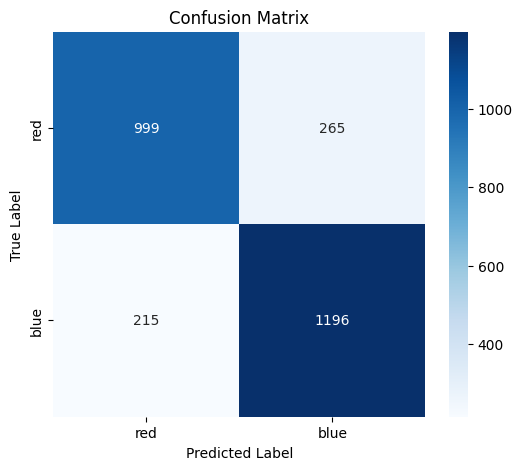

In [72]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['red', 'blue'], yticklabels=['red', 'blue'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

bst_red = final_red.get_booster()
bst_blue = final_blue.get_booster()

print(bst_red.feature_names)

bst_red.save_model("red_model.json")
bst_blue.save_model("blue_model.json")

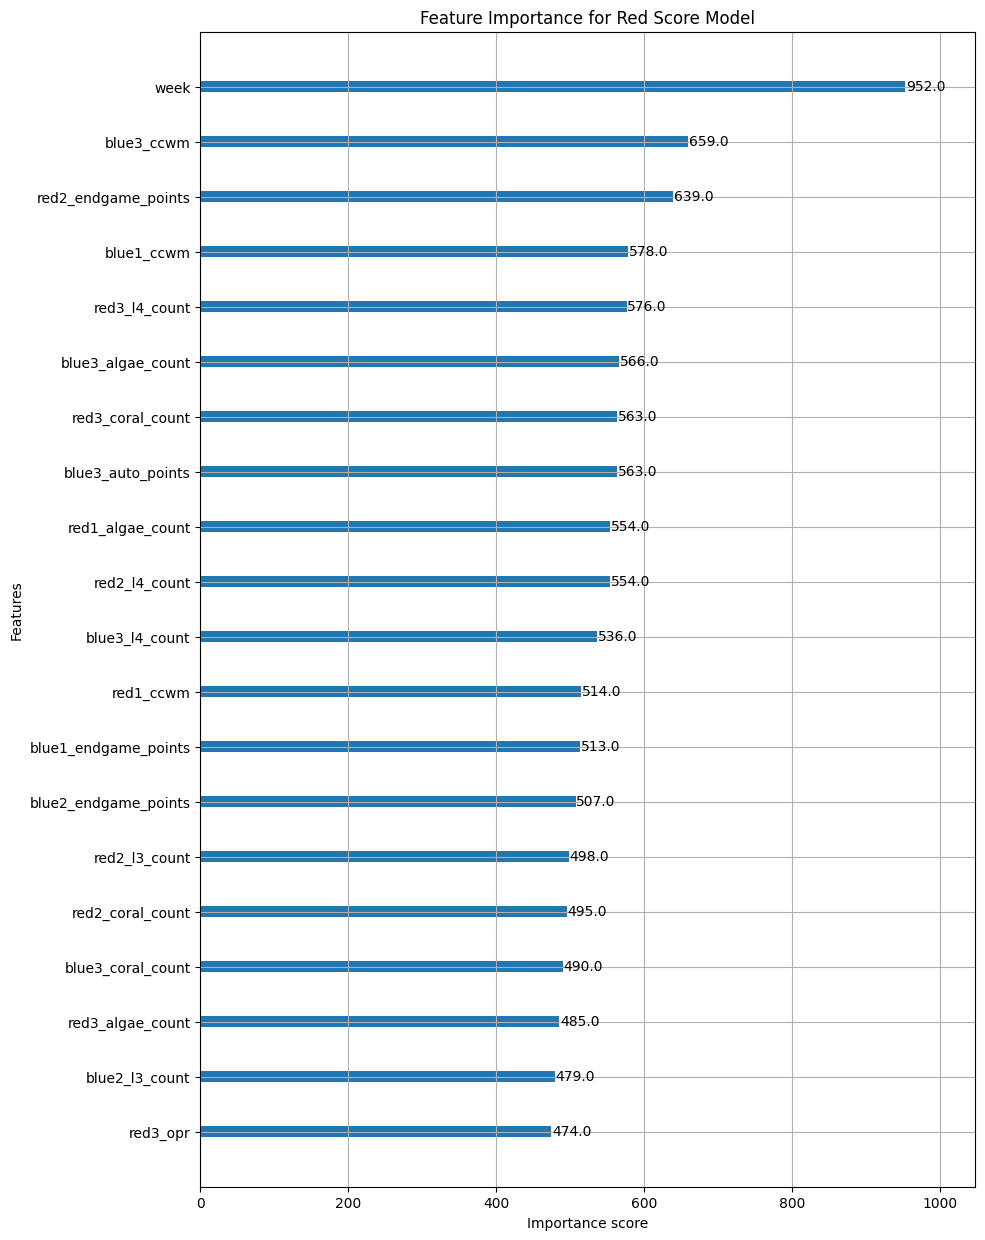

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(final_red, ax=ax, max_num_features=20) 
plt.title("Feature Importance for Red Score Model")
plt.show()

In [ ]:
from xgboost import plot_tree
import xgboost
import matplotlib.pyplot as plt

redmodel = xgboost.XGBRegressor()
redmodel.load_model("models/regression/red_model.json")
plot_tree(redmodel)
plt.title("XGBoost model")
plt.show()